In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [3]:
gene_list = pd.read_csv('hallmark_surv_curated.csv')
gene_list

,IA,TPI,GIM,SPS,AID,ERI,RCD,EGS,DCE,AIM
0,CCR3,PLCB2,BLM,PAK2,HCST,E2F1,PAK2,PAK2,PRKAG3,CDH15
1,HIF1A,PRKCG,FANCI,GNG3,HIF1A,PIK3CD,IL6R,GNG3,NFE2L2,PAK2
2,PRKCG,TNFAIP3,RECQL4,IL6R,PLCB2,NRAS,PLK1,RBL1,GPI,PLCB2
3,MMP1,CARD11,POLD3,PLCB2,CXCR1,PIK3CG,ELK1,FZD2,HIF1A,FZD2
4,PIK3CD,GNB1,PCNA,PKN3,CCL26,PRKCA,BCL6,WNT3A,PFKP,WNT3A
...,...,...,...,...,...,...,...,...,...,...
202,NaN,NaN,NaN,PIM1,NaN,NaN,NaN,NaN,NaN,NaN
203,NaN,NaN,NaN,CSF3,NaN,NaN,NaN,NaN,NaN,NaN
204,NaN,NaN,NaN,BARD1,NaN,NaN,NaN,NaN,NaN,NaN
205,NaN,NaN,NaN,GNA12,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
meta_neg = pd.read_csv('meta_neg_sep_hallmark.csv', index_col=(0))
meta_neg['sample'] = meta_neg.index.str.split('&').str[0]
meta_neg.index = [f'Negative_{j+1}' for j in range(len(meta_neg.index))]
meta_neg['Class'] = 0
meta_neg

,Cancer,Hallmark,sample,Class
Negative_1,Ovarian,AID,1,0
Negative_2,Breast,AID,1,0
Negative_3,Ovarian,AID,1,0
Negative_4,Prostate,AIM,1,0
Negative_5,Prostate,AIM,1,0
...,...,...,...,...
Negative_39139,Hematologic,ERI,tFL1,0
Negative_39140,Hematologic,IA,tFL1,0
Negative_39141,Hematologic,IA,tFL1,0
Negative_39142,Hematologic,ERI,tFL2,0


In [5]:
meta_pos = pd.read_csv('meta_pos_sep_hallmark.csv', index_col=(0))
meta_pos['sample'] = meta_pos.index.str.split('&').str[0]
meta_pos.index = [f'Positive_{j+1}' for j in range(len(meta_pos.index))]
meta_pos['Class'] = 1
meta_pos

,Cancer,Hallmark,sample,Class
Positive_1,Ovarian,AIM,1,1
Positive_2,Ovarian,AIM,1,1
Positive_3,Ovarian,AIM,1,1
Positive_4,Ovarian,AIM,1,1
Positive_5,Ovarian,AIM,1,1
...,...,...,...,...
Positive_28783,Hematologic,EGS,tFL2,1
Positive_28784,Hematologic,ERI,tFL2,1
Positive_28785,Hematologic,ERI,tFL2,1
Positive_28786,Hematologic,IA,tFL2,1


In [6]:
data_pos = pd.read_csv('data_pos_sep_hallmark.csv',index_col=(0))
data_pos.index = [f'Positive_{j+1}' for j in range(len(data_pos.index))]
data_pos

,NOC2L,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,SDF4,B3GALT6,UBE2J2,ACAP3,...,AP000676.5,SNHG29,AC090498.1,LRRC75A-AS1,MTCO2P12,C19ORF43,C14ORF2,UQCR11.1,COX1,COX2
Positive_1,91,213,229,12,6,25,119,70,108,8,...,0,0,0,0,0,0,0,0,0,0
Positive_2,109,186,132,15,9,7,132,87,116,11,...,0,0,0,0,0,0,0,0,0,0
Positive_3,125,206,125,22,14,22,154,100,126,14,...,0,0,0,0,0,0,0,0,0,0
Positive_4,112,167,177,20,8,11,145,101,121,13,...,0,0,0,0,0,0,0,0,0,0
Positive_5,109,234,159,15,10,23,141,56,120,10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Positive_28783,18,3,26,0,20,35,41,4,31,3,...,0,0,0,0,0,0,0,0,0,0
Positive_28784,16,0,13,1,0,0,24,3,23,2,...,0,0,0,0,0,0,0,0,0,0
Positive_28785,29,0,19,0,0,5,32,3,30,2,...,0,0,0,0,0,0,0,0,0,0
Positive_28786,25,0,22,0,8,17,27,3,30,4,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data_neg = pd.read_csv('data_neg_sep_hallmark.csv',index_col=(0))
data_neg.index = [f'Negative_{j+1}' for j in range(len(data_neg.index))]
data_neg

,SAMD11,NOC2L,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,SDF4,B3GALT6,C1QTNF12,...,PPP1R2C,AC073111.5,AL117339.5,MTCO2P12,MT-RNR1,MT-RNR2,COX1,COX2,COX3,ND4
Negative_1,3,39,66,63,5,3,1,47,22,0,...,0,0,0,0,0,0,0,0,0,0
Negative_2,0,6,5,201,0,65,139,8,0,0,...,0,0,0,0,0,0,0,0,0,0
Negative_3,11,34,79,41,5,6,10,54,13,3,...,0,0,0,0,0,0,0,0,0,0
Negative_4,1,14,36,27,1,0,0,33,4,0,...,0,0,0,0,0,0,0,0,0,0
Negative_5,0,9,35,29,3,0,1,29,3,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Negative_39139,0,12,4,76,0,17,37,14,6,0,...,0,0,0,0,0,0,0,0,0,0
Negative_39140,1,9,2,71,0,11,9,12,2,0,...,0,0,0,0,0,0,0,0,0,0
Negative_39141,0,3,2,129,3,25,34,24,8,0,...,0,0,0,0,0,0,0,0,0,0
Negative_39142,0,22,0,33,0,29,33,33,2,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
common = (list(set(data_pos.columns) & set(data_neg.columns)))
len(common)

9326

In [9]:
data_pos1 = data_pos[common]
data_pos1

,LRRC75A,ECHDC1,BTBD7,TSN,RXRA,GEMIN7,RBKS,WDR1,C11orf49,DHX57,...,EIF4E2,METTL1,ZNF76,B4GALT1,FKBP2,MYLK,GPS1,APOL1,MT-ND1,DYNLL1
Positive_1,46,64,114,72,20,27,4,280,15,14,...,94,65,9,155,182,205,19,31,5662,229
Positive_2,56,62,111,92,13,20,6,314,16,15,...,104,64,6,199,199,159,15,41,6120,205
Positive_3,71,74,130,106,13,31,4,318,10,19,...,114,71,7,193,231,182,30,31,6484,284
Positive_4,78,58,120,92,15,34,3,295,10,17,...,132,49,9,187,179,258,16,34,6834,234
Positive_5,55,71,151,99,3,40,0,322,14,13,...,97,66,8,175,211,188,37,24,6833,212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Positive_28783,15,43,6,22,1,7,5,64,12,4,...,19,0,4,29,42,2,32,0,225,261
Positive_28784,4,30,8,27,1,16,3,60,6,5,...,15,2,7,19,27,1,21,1,249,224
Positive_28785,14,40,10,28,0,8,2,65,8,2,...,21,2,8,22,29,0,18,2,296,255
Positive_28786,12,38,5,23,1,26,3,67,8,5,...,14,3,14,23,26,0,21,6,285,300


In [10]:
data_neg1 = data_neg[common]
data_neg1

,LRRC75A,ECHDC1,BTBD7,TSN,RXRA,GEMIN7,RBKS,WDR1,C11orf49,DHX57,...,EIF4E2,METTL1,ZNF76,B4GALT1,FKBP2,MYLK,GPS1,APOL1,MT-ND1,DYNLL1
Negative_1,27,23,32,45,7,5,2,69,5,12,...,33,30,5,60,86,189,8,7,2521,143
Negative_2,1,11,4,13,1,6,4,30,1,1,...,9,1,4,4,15,0,4,3,111,79
Negative_3,20,32,37,42,10,6,0,99,13,6,...,21,33,4,58,89,207,9,6,2560,174
Negative_4,5,3,4,0,3,4,0,13,4,4,...,12,7,1,14,71,3,10,0,0,109
Negative_5,5,3,3,6,4,6,0,14,2,3,...,11,3,0,4,77,2,9,1,0,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Negative_39139,2,11,10,15,2,9,1,36,5,2,...,10,0,7,29,28,1,10,2,249,129
Negative_39140,11,22,8,10,0,11,2,30,5,4,...,9,3,3,39,18,0,8,0,232,118
Negative_39141,2,13,6,21,0,14,0,38,4,2,...,15,2,3,20,23,1,4,2,234,146
Negative_39142,8,29,6,34,0,14,1,83,7,2,...,25,0,11,17,37,0,16,2,280,248


In [18]:
hall_list = ['AIM', 'DCE', 'EGS', 'GIM', 'RCD', 'SPS', 'AID', 'IA', 'ERI', 'TPI']

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 1.11 seconds.

Fitting dispersions...
... done in 5.24 seconds.

Fitting dispersion trend curve...
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 5.23 seconds.

Fitting LFCs...
... done in 6.32 seconds.

Calculating cook's distance...
... done in 3.73 seconds.

Replacing 334 outlier genes.

Fitting dispersions...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 0.37 seconds.

Fitting LFCs...
... done in 2.29 seconds.

Running Wald tests...
... done in 2.78 seconds.

/data1/miniconda3/envs/tf/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Log2 fold change & Wald test p-value: Class 1 vs 0
            baseMean  log2FoldChange     lfcSE       stat         pvalue  \
LRRC75A     7.597042       -1.232794  0.047296 -26.065450  8.989442e-150   
ECHDC1     26.741517       -0.133710  0.019182  -6.970555   3.156938e-12   
BTBD7      15.718906       -0.610530  0.030356 -20.112516   5.733987e-90   
TSN        18.462416       -0.279199  0.013795 -20.238868   4.452816e-91   
RXRA       13.769762        1.126911  0.031007  36.344250  3.239013e-289   
...              ...             ...       ...        ...            ...   
MYLK        8.732299       -0.284620  0.057329  -4.964691   6.881040e-07   
GPS1       19.897237        0.093951  0.017758   5.290586   1.219253e-07   
APOL1       9.269558        0.444592  0.032878  13.522528   1.151503e-41   
MT-ND1   1198.365558       -0.252959  0.045288  -5.585623   2.328645e-08   
DYNLL1    188.883408       -0.044630  0.022009  -2.027801   4.258060e-02   

                  padj  
LRRC75A  2.

/tmp/ipykernel_263261/4264902000.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


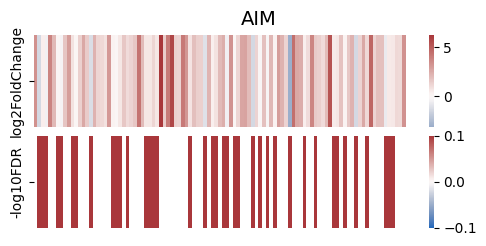

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 1.22 seconds.

Fitting dispersions...
... done in 5.62 seconds.

Fitting dispersion trend curve...
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 5.16 seconds.

Fitting LFCs...
... done in 5.21 seconds.

Calculating cook's distance...
... done in 4.45 seconds.

Replacing 284 outlier genes.

Fitting dispersions...
... done in 0.37 seconds.

Fitting MAP dispersions...
... done in 0.32 seconds.

Fitting LFCs...
... done in 1.59 seconds.

Running Wald tests...
... done in 3.18 seconds.

/data1/miniconda3/envs/tf/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Log2 fold change & Wald test p-value: Class 1 vs 0
            baseMean  log2FoldChange     lfcSE       stat         pvalue  \
LRRC75A     9.067829       -0.811949  0.046435 -17.485534   1.846735e-68   
ECHDC1     28.679941       -0.199388  0.017294 -11.529135   9.408436e-31   
BTBD7      21.280140       -1.692195  0.027854 -60.752286   0.000000e+00   
TSN        21.945980        0.194497  0.014969  12.993019   1.340330e-38   
RXRA       12.556921        0.065119  0.029445   2.211592   2.699484e-02   
...              ...             ...       ...        ...            ...   
MYLK       13.138828       -0.409313  0.052378  -7.814638   5.512129e-15   
GPS1       20.714811        0.525539  0.016867  31.158470  3.894579e-213   
APOL1      13.224988        0.254615  0.035702   7.131708   9.913090e-13   
MT-ND1   1230.337639       -0.110611  0.047268  -2.340066   1.928033e-02   
DYNLL1    217.792461        0.668511  0.022383  29.867334  5.228840e-196   

                  padj  
LRRC75A   3

/tmp/ipykernel_263261/4264902000.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


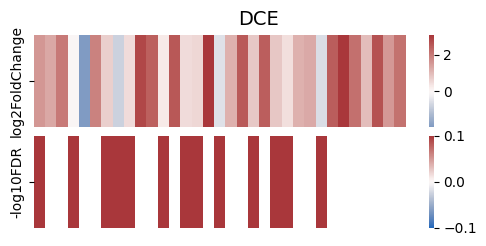

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.99 seconds.

Fitting dispersions...
... done in 5.21 seconds.

Fitting dispersion trend curve...
... done in 0.25 seconds.

Fitting MAP dispersions...
... done in 4.88 seconds.

Fitting LFCs...
... done in 4.77 seconds.

Calculating cook's distance...
... done in 3.96 seconds.

Replacing 335 outlier genes.

Fitting dispersions...
... done in 0.43 seconds.

Fitting MAP dispersions...
... done in 0.28 seconds.

Fitting LFCs...
... done in 1.58 seconds.

Running Wald tests...
... done in 2.49 seconds.

/data1/miniconda3/envs/tf/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Log2 fold change & Wald test p-value: Class 1 vs 0
            baseMean  log2FoldChange     lfcSE       stat         pvalue  \
LRRC75A     8.181781       -1.360323  0.050116 -27.143364  3.032542e-162   
ECHDC1     28.787924       -0.567023  0.019712 -28.765682  5.766638e-182   
BTBD7      17.869113       -0.554216  0.034587 -16.023644   8.737591e-58   
TSN        19.629162       -0.384133  0.015791 -24.326459  1.029133e-130   
RXRA       12.833846        0.434638  0.032566  13.346355   1.243876e-40   
...              ...             ...       ...        ...            ...   
MYLK       11.000004       -1.575044  0.058249 -27.039813  5.032833e-161   
GPS1       20.104203       -0.228986  0.017568 -13.033986   7.840245e-39   
APOL1      10.226677       -0.169284  0.032960  -5.136064   2.805517e-07   
MT-ND1   1213.885981       -0.550169  0.047591 -11.560416   6.539108e-31   
DYNLL1    196.771810       -0.246874  0.022435 -11.004189   3.647834e-28   

                  padj  
LRRC75A  1.

/tmp/ipykernel_263261/4264902000.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


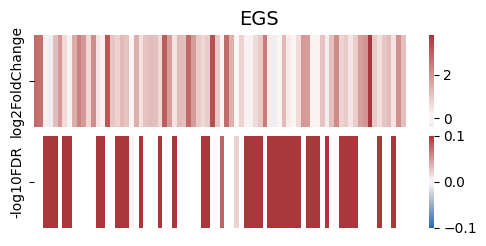

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.24 seconds.

Fitting dispersions...
... done in 2.30 seconds.

Fitting dispersion trend curve...
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 2.33 seconds.

Fitting LFCs...
... done in 2.35 seconds.

Calculating cook's distance...
... done in 0.91 seconds.

Replacing 403 outlier genes.

Fitting dispersions...
... done in 0.57 seconds.

Fitting MAP dispersions...
... done in 0.62 seconds.

Fitting LFCs...
... done in 0.78 seconds.

Running Wald tests...
... done in 1.27 seconds.

/data1/miniconda3/envs/tf/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Log2 fold change & Wald test p-value: Class 1 vs 0
            baseMean  log2FoldChange     lfcSE       stat        pvalue  \
LRRC75A     7.934912        0.586011  0.104394   5.613474  1.983049e-08   
ECHDC1     26.388141        0.116861  0.039486   2.959534  3.081049e-03   
BTBD7      18.754147        0.517229  0.072656   7.118842  1.088372e-12   
TSN        23.921103        0.626713  0.036931  16.970052  1.368110e-64   
RXRA        9.663565       -0.962480  0.065211 -14.759589  2.669005e-49   
...              ...             ...       ...        ...           ...   
MYLK       13.969214       -1.726296  0.102753 -16.800378  2.424948e-63   
GPS1       23.350087        0.088184  0.034357   2.566672  1.026797e-02   
APOL1       9.830051       -1.364175  0.073147 -18.649843  1.266476e-77   
MT-ND1   1054.283306       -0.212715  0.087904  -2.419858  1.552657e-02   
DYNLL1    211.785994        0.183688  0.032301   5.686824  1.294239e-08   

                 padj  
LRRC75A  3.238737e-08  


/tmp/ipykernel_263261/4264902000.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


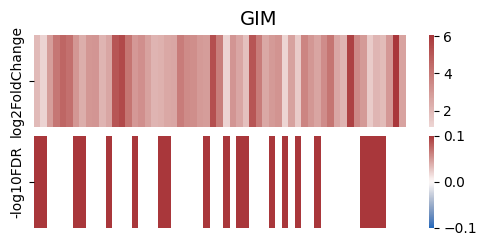

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.82 seconds.

Fitting dispersions...
... done in 4.35 seconds.

Fitting dispersion trend curve...
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 4.12 seconds.

Fitting LFCs...
... done in 4.05 seconds.

Calculating cook's distance...
... done in 3.47 seconds.

Replacing 396 outlier genes.

Fitting dispersions...
... done in 0.39 seconds.

Fitting MAP dispersions...
... done in 0.31 seconds.

Fitting LFCs...
... done in 1.16 seconds.

Running Wald tests...
... done in 2.10 seconds.

/data1/miniconda3/envs/tf/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Log2 fold change & Wald test p-value: Class 1 vs 0
            baseMean  log2FoldChange     lfcSE       stat         pvalue  \
LRRC75A     9.378913       -1.239407  0.054258 -22.842878  1.720138e-115   
ECHDC1     30.807469       -0.350288  0.021184 -16.535820   2.026018e-61   
BTBD7      18.853333       -0.355860  0.038235  -9.307189   1.312598e-20   
TSN        20.735964       -0.447017  0.017338 -25.783029  1.374546e-146   
RXRA       16.180195        1.423561  0.037715  37.745432   0.000000e+00   
...              ...             ...       ...        ...            ...   
MYLK        9.387982       -1.137904  0.065559 -17.356861   1.750364e-67   
GPS1       20.121376       -0.177052  0.019311  -9.168240   4.808063e-20   
APOL1      10.894462       -0.055592  0.038174  -1.456257   1.453217e-01   
MT-ND1   1313.242689       -0.101039  0.053877  -1.875366   6.074245e-02   
DYNLL1    207.695862       -0.033456  0.025051  -1.335552   1.816957e-01   

                  padj  
LRRC75A  4.

/tmp/ipykernel_263261/4264902000.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


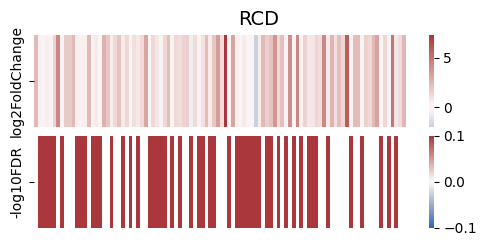

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 1.04 seconds.

Fitting dispersions...
... done in 4.91 seconds.

Fitting dispersion trend curve...
... done in 0.20 seconds.

Fitting MAP dispersions...
... done in 5.11 seconds.

Fitting LFCs...
... done in 5.96 seconds.

Calculating cook's distance...
... done in 4.13 seconds.

Replacing 289 outlier genes.

Fitting dispersions...
... done in 0.45 seconds.

Fitting MAP dispersions...
... done in 0.41 seconds.

Fitting LFCs...
... done in 1.60 seconds.

Running Wald tests...
... done in 3.04 seconds.

/data1/miniconda3/envs/tf/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Log2 fold change & Wald test p-value: Class 1 vs 0
            baseMean  log2FoldChange     lfcSE       stat         pvalue  \
LRRC75A     7.734782       -1.463964  0.048127 -30.418888  3.090878e-203   
ECHDC1     27.887643       -0.373518  0.019446 -19.207647   3.194208e-82   
BTBD7      16.408570       -0.804698  0.030204 -26.641705  2.233081e-156   
TSN        18.536533       -0.341233  0.014628 -23.327441  2.335441e-120   
RXRA       13.254442        0.817136  0.030050  27.192380  7.992744e-163   
...              ...             ...       ...        ...            ...   
MYLK       10.560959       -2.314872  0.056754 -40.788003   0.000000e+00   
GPS1       20.297312       -0.099119  0.018424  -5.379903   7.452587e-08   
APOL1       9.060992       -0.143371  0.032005  -4.479662   7.476142e-06   
MT-ND1   1208.979108       -0.463221  0.049000  -9.453482   3.277429e-21   
DYNLL1    189.994923       -0.227587  0.023677  -9.612067   7.110692e-22   

                  padj  
LRRC75A  9.

/tmp/ipykernel_263261/4264902000.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


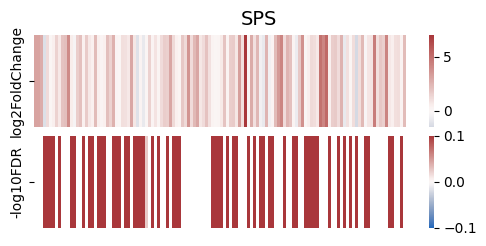

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.90 seconds.

Fitting dispersions...
... done in 4.74 seconds.

Fitting dispersion trend curve...
... done in 0.25 seconds.

Fitting MAP dispersions...
... done in 4.77 seconds.

Fitting LFCs...
... done in 6.40 seconds.

Calculating cook's distance...
... done in 3.45 seconds.

Replacing 307 outlier genes.

Fitting dispersions...
... done in 0.49 seconds.

Fitting MAP dispersions...
... done in 0.41 seconds.

Fitting LFCs...
... done in 2.29 seconds.

Running Wald tests...
... done in 2.96 seconds.

/data1/miniconda3/envs/tf/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Log2 fold change & Wald test p-value: Class 1 vs 0
            baseMean  log2FoldChange     lfcSE       stat         pvalue  \
LRRC75A     8.491675       -1.299808  0.052277 -24.864074  1.821486e-136   
ECHDC1     29.752970       -0.128059  0.018640  -6.870070   6.417047e-12   
BTBD7      19.004066       -0.747498  0.033477 -22.328515  1.953096e-110   
TSN        21.014721       -0.674271  0.015838 -42.573164   0.000000e+00   
RXRA       16.845009        1.238411  0.031452  39.375158   0.000000e+00   
...              ...             ...       ...        ...            ...   
MYLK       10.526354       -3.603024  0.060130 -59.920579   0.000000e+00   
GPS1       21.968235       -0.149590  0.018491  -8.090090   5.962084e-16   
APOL1      10.358272       -0.229534  0.034574  -6.638980   3.158618e-11   
MT-ND1   1263.190533       -0.163041  0.052953  -3.078964   2.077217e-03   
DYNLL1    209.655466       -0.272185  0.023117 -11.774085   5.308986e-32   

                  padj  
LRRC75A  3.

/tmp/ipykernel_263261/4264902000.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


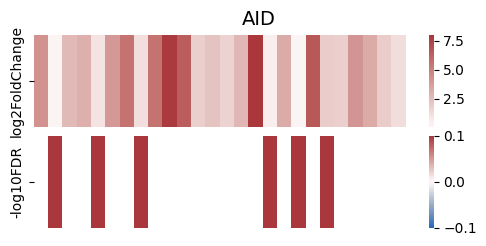

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 1.08 seconds.

Fitting dispersions...
... done in 5.00 seconds.

Fitting dispersion trend curve...
... done in 0.26 seconds.

Fitting MAP dispersions...
... done in 4.88 seconds.

Fitting LFCs...
... done in 5.34 seconds.

Calculating cook's distance...
... done in 3.82 seconds.

Replacing 387 outlier genes.

Fitting dispersions...
... done in 0.38 seconds.

Fitting MAP dispersions...
... done in 0.33 seconds.

Fitting LFCs...
... done in 1.80 seconds.

Running Wald tests...
... done in 2.69 seconds.

/data1/miniconda3/envs/tf/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Log2 fold change & Wald test p-value: Class 1 vs 0
           baseMean  log2FoldChange     lfcSE       stat         pvalue  \
LRRC75A    4.943940       -0.764107  0.056571 -13.506960   1.422765e-41   
ECHDC1    19.540640       -0.143598  0.020134  -7.132192   9.878288e-13   
BTBD7     13.319333       -0.098624  0.037209  -2.650544   8.036224e-03   
TSN       14.587992       -0.421091  0.017359 -24.257328  5.533826e-130   
RXRA       9.195241        1.337780  0.035247  37.954877   0.000000e+00   
...             ...             ...       ...        ...            ...   
MYLK       8.744821       -0.200042  0.065327  -3.062153   2.197514e-03   
GPS1      15.314755       -0.315231  0.019824 -15.901392   6.197210e-57   
APOL1      7.565916        0.402748  0.034649  11.623772   3.120468e-31   
MT-ND1   814.760613        0.193095  0.054444   3.546696   3.900951e-04   
DYNLL1   144.090038        0.009961  0.020616   0.483175   6.289717e-01   

                  padj  
LRRC75A   2.604724e-41 

/tmp/ipykernel_263261/4264902000.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


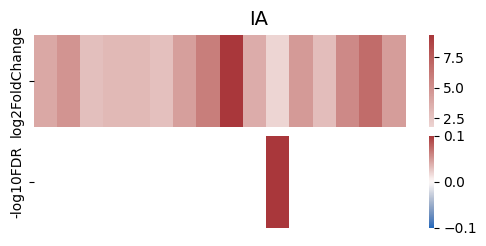

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 1.53 seconds.

Fitting dispersions...
... done in 8.28 seconds.

Fitting dispersion trend curve...
... done in 0.26 seconds.

Fitting MAP dispersions...
... done in 7.87 seconds.

Fitting LFCs...
... done in 5.85 seconds.

Calculating cook's distance...
... done in 5.83 seconds.

Replacing 335 outlier genes.

Fitting dispersions...
... done in 0.46 seconds.

Fitting MAP dispersions...
... done in 0.39 seconds.

Fitting LFCs...
... done in 1.85 seconds.

Running Wald tests...
... done in 3.72 seconds.

/data1/miniconda3/envs/tf/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Log2 fold change & Wald test p-value: Class 1 vs 0
            baseMean  log2FoldChange     lfcSE       stat         pvalue  \
LRRC75A     6.605212        0.002170  0.043033   0.050433   9.597770e-01   
ECHDC1     23.674219        0.000066  0.016599   0.003949   9.968494e-01   
BTBD7      13.699409        0.743243  0.025187  29.508982  2.208025e-191   
TSN        18.492219        0.021178  0.013141   1.611612   1.070464e-01   
RXRA        9.914589        0.520673  0.026201  19.872308   7.067757e-88   
...              ...             ...       ...        ...            ...   
MYLK       12.274816       -0.638247  0.051260 -12.451232   1.377027e-35   
GPS1       19.278811       -0.163161  0.015697 -10.394624   2.623182e-25   
APOL1      10.909878       -0.481789  0.031576 -15.258119   1.453797e-52   
MT-ND1   1138.320389       -0.068715  0.043669  -1.573530   1.155963e-01   
DYNLL1    199.275139       -0.407672  0.017534 -23.249718  1.431917e-119   

                  padj  
LRRC75A   9

/tmp/ipykernel_263261/4264902000.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


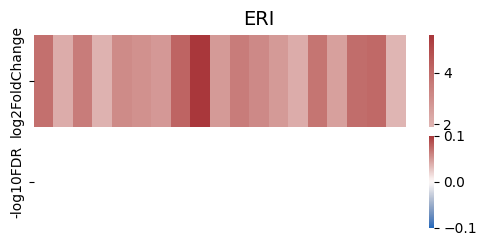

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 1.04 seconds.

Fitting dispersions...
... done in 5.02 seconds.

Fitting dispersion trend curve...
... done in 0.26 seconds.

Fitting MAP dispersions...
... done in 5.07 seconds.

Fitting LFCs...
... done in 6.55 seconds.

Calculating cook's distance...
... done in 3.92 seconds.

Replacing 306 outlier genes.

Fitting dispersions...
... done in 0.35 seconds.

Fitting MAP dispersions...
... done in 0.35 seconds.

Fitting LFCs...
... done in 2.90 seconds.

Running Wald tests...
... done in 2.82 seconds.

/data1/miniconda3/envs/tf/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Log2 fold change & Wald test p-value: Class 1 vs 0
            baseMean  log2FoldChange     lfcSE       stat        pvalue  \
LRRC75A     8.182894       -0.854819  0.053496 -15.979055  1.788375e-57   
ECHDC1     30.966694        0.060281  0.020617   2.923790  3.457978e-03   
BTBD7      16.973624       -0.186472  0.028167  -6.620281  3.585170e-11   
TSN        23.201269       -0.612362  0.015225 -40.219853  0.000000e+00   
RXRA       16.443081        1.434226  0.028379  50.538231  0.000000e+00   
...              ...             ...       ...        ...           ...   
MYLK       15.802276       -3.862464  0.060415 -63.932591  0.000000e+00   
GPS1       25.607854       -0.231697  0.018980 -12.207576  2.832021e-34   
APOL1      11.075064       -0.070773  0.038835  -1.822386  6.839639e-02   
MT-ND1   1478.771666       -0.198995  0.058102  -3.424927  6.149649e-04   
DYNLL1    260.486905       -0.333084  0.021913 -15.200296  3.520285e-52   

                 padj  
LRRC75A  2.801077e-57  


/tmp/ipykernel_263261/4264902000.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


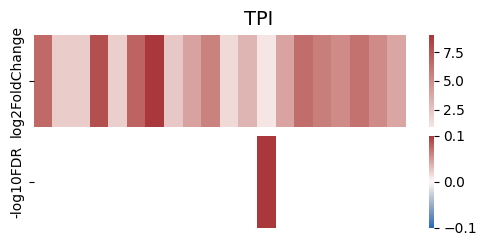

In [19]:
for i in hall_list:
    meta_net = pd.concat([meta_pos[meta_pos['Hallmark'] == i], meta_neg[meta_neg['Hallmark'] == i]])
    data_net = pd.concat([data_pos1[data_pos1.index.isin(meta_net.index)], data_neg1[data_neg1.index.isin(meta_net.index)]])
    inference = DefaultInference(n_cpus=20)
    dds = DeseqDataSet(
        counts=data_net,
        metadata=meta_net,
        design="~Class",
        refit_cooks=True,
        inference=inference,
        n_cpus=20, # n_cpus can be specified here or in the inference object
    )
    dds.deseq2()
    ds = DeseqStats(dds, contrast=["Class", 1, 0], inference=inference)
    ds.summary()
    req_gene = gene_list[i].dropna().to_list()
    ds.results_df = ds.results_df[ds.results_df.index.isin(req_gene)].reset_index()
    ds.results_df['-log10FDR'] = -np.log10(ds.results_df['pvalue'])
    # Create the figure
    fig, axs = plt.subplots(2, 1, figsize=(6, 2.5), sharex=True,
                            gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.1})
    fig.suptitle(i, fontsize=14)
    # First row: log2FoldChange
    sns.heatmap(
        ds.results_df[['log2FoldChange']].T,
        ax=axs[0],
        cmap='vlag',
        cbar=True,
        center=0,
        annot=False,
        fmt=".1f"
    )
    axs[0].set_ylabel('')
    axs[0].tick_params(bottom=False, labelbottom=False)
    
    # Second row: -log10fdr
    sns.heatmap(
        ds.results_df[['-log10FDR']].T,
        ax=axs[1],
        cmap='vlag',
        cbar=True,
        annot=False,
        fmt=".1f"
    )
    axs[1].set_ylabel('')
    axs[1].tick_params(bottom=False, labelbottom=False)    
    plt.tight_layout()
    plt.savefig('volcano_{}.png'.format(i), bbox_inches='tight', dpi=1200)
    plt.show()